In [3]:
import sys
sys.path.append("../")
import urllib.request
from glob import glob

import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.stats import binned_statistic
import pandas as pd
from tqdm import *
from astropy.cosmology import z_at_value
import astropy.units as u
from feynman import Diagram

from grf.units import *
from grf.grf import TransitionProbabilities, PerturbedProbability, FIRAS
from grf.simulations import GaussianRandomFieldBoxes
from grf.pk_interp import PowerSpectrumGridInterpolator

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/smsharma/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [4]:
# Plot parameters

from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [5]:
plots_dir = "../paper/draft-formalism/plots/"

In [6]:
# Load a power spectrum
pspec = PowerSpectrumGridInterpolator("nonlin_matter_bj")

## Plot of GRF at higher $z$

In [7]:
n_mc = 3

z_fid = 100
z_range = [95, 105]
k_max = 20
n_points = 1000
seeds = [[344112], [321], [534], [2113]]

In [9]:
z_crossings_collect = []
P_collect = []

for i_mc in tqdm_notebook(range(n_mc)):

    GRFB = GaussianRandomFieldBoxes(z_fid=z_fid, z_range=z_range, k_max=k_max, n_points=n_points, r_filter=4, log_pk_interp=pspec, z_dep_P=0, run=False)
    GRFB.get_box_properties()
    GRFB.simulate_grf(seeds=seeds[i_mc])

    step = 2 * np.ceil(GRFB.filter_size / GRFB.spacing_size)
    idxs = np.arange(0, np.shape(GRFB.fields[0])[0], step).astype(np.int32)

    for i in tqdm_notebook(idxs):
        for j in idxs:
            GRFB.calculate_transition_prob_custom(np.array(GRFB.fields)[:, i, :, j])
            z_crossings_collect.append(GRFB.z_crossings_collect_temp)
            P_collect.append(GRFB.P_collect_temp)

P_collect = np.array(P_collect)
z_crossings_collect = np.array(z_crossings_collect)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/Users/smsharma/anaconda3/lib/python3.7/site-packages/nbodykit/filters.py:31: RuntimeWarning: invalid value encountered in true_divide
  w = 3 * (numpy.sin(kr) / kr **3 - numpy.cos(kr) / kr ** 2)
/Users/smsharma/anaconda3/lib/python3.7/site-packages/nbodykit/filters.py:31: RuntimeWarning: divide by zero encountered in true_divide
  w = 3 * (numpy.sin(kr) / kr **3 - numpy.cos(kr) / kr ** 2)
/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [12]:
firas = FIRAS(pspec)
z_ary, dP_dz_ary, _, _  = firas.P_tot_perturb([5.9e-6 * eV], 1., GRFB.m_A_fid , pdf="gaussian", k_max=k_max, r_smooth=GRFB.filter_sizes[0])
dP_dz_ary = dP_dz_ary[0]

../grf/grf.py:633: FutureWarning: read_table is deprecated, use read_csv instead.
  names=['freq', 'I', 'residual', 'uncert', 'poles'])


In [10]:
from scipy.stats import binned_statistic

n_mc = len(z_crossings_collect)

y = []
for i_mc in range(n_mc):
    _y, _x, _ = binned_statistic(z_crossings_collect[i_mc], P_collect[i_mc], 'sum', bins=11, range=z_range)
    y.append(_y)
x = _x
bin_centers = (x[1:] + x[:-1])/2.

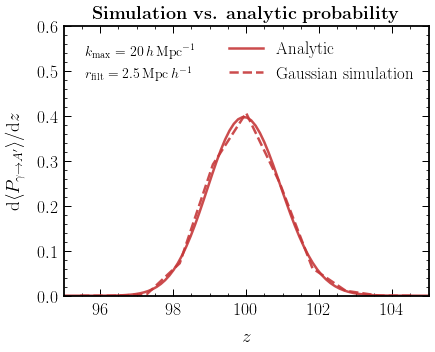

In [14]:
norm = (bin_centers[1] - bin_centers[0]) * np.sum(np.mean(y, axis=0))

plt.plot(z_ary, dP_dz_ary  / np.trapz(dP_dz_ary[(z_ary > z_range[0]) * (z_ary < z_range[1])], z_ary[(z_ary > z_range[0]) * (z_ary < z_range[1])]), label="Analytic", color=cols_default[0])
plt.plot(bin_centers, np.mean(y, axis=0) / norm, label="Gaussian simulation", color=cols_default[0], ls='--')

plt.xlim(z_range[0], z_range[1])
plt.ylim(0, .6)
plt.ylabel(r"$\mathrm{d}\langle P_{\gamma\to A'}\rangle/\mathrm{d}z$")
plt.xlabel("$z$")

plt.title(r"\bf{Simulation vs. analytic probability}")

plt.text(95.6, 0.55 - 0.02, "$k_\mathrm{max}=20\,h\,\mathrm{Mpc}^{-1}$", fontsize=14)
plt.text(95.6, 0.502 - 0.02, "$r_\mathrm{filt}=2.5\,\mathrm{Mpc}\,h^{-1}$", fontsize=14)

plt.legend()

plt.tight_layout()
plt.savefig(plots_dir + "dPdz_GRF_sim.pdf")

Works!

## Lognormal vs Gaussian

In [140]:
firas = FIRAS(pspec)

../grf/grf.py:633: FutureWarning: read_table is deprecated, use read_csv instead.
  names=['freq', 'I', 'residual', 'uncert', 'poles'])


In [141]:
def lognormal_transform(delta, sigma):
    t = 1 + sigma ** 2
    delta /= sigma
    delta *= np.sqrt(np.log(t))
    delta = np.exp(delta, out=delta)
    delta /= np.sqrt(t)
    return delta

In [142]:
normal_draws = np.random.normal(1, 2, 10000000)
lognormal_draws = lognormal_transform(normal_draws - 1, 2)

In [143]:
np.var(normal_draws), np.var(lognormal_draws)

(3.997902285224804, 3.945813437097718)

In [144]:
np.mean(normal_draws), np.mean(lognormal_draws)

(0.9993225330806487, 0.9990296080547404)

In [145]:
# plt.hist(normal_draws, bins=np.linspace(-6, 8 ,1000));
# plt.hist(lognormal_draws, bins=np.linspace(-6, 8 ,1000));

In [146]:
z_fid = 5
z_range = [4, 6]
k_max = 10
n_points = 50
i_seed = 12

n_mc = 30

z_crossings_collect = []
P_collect = []

for i_mc in tqdm_notebook(range(n_mc)):
    
    GRFB = GaussianRandomFieldBoxes(z_fid=z_fid, z_range=z_range, k_max=k_max, n_points=n_points, r_filter=4, log_pk_interp=pspec, z_dep_P=1, run=False)
    GRFB.get_box_properties()
    GRFB.simulate_grf(seeds=np.arange(i_seed, i_seed + GRFB.n_boxes))
    
    i_seed += GRFB.n_boxes + 1
    
    step = 2 * np.ceil(GRFB.filter_size / GRFB.spacing_size)
    
    idxs = np.arange(0, np.shape(GRFB.fields[-1])[0], step).astype(np.int32)
    len(idxs)
    
    sigmas = [np.sqrt(firas._delta_sq(z, 1e-4, k_max, pspec, r_smooth=r)[0]) for z, r in zip(GRFB.z_center_ary, GRFB.filter_sizes)]
    sigmas = [np.sqrt(np.var(GRFB.fields[i_b])) for i_b in range(GRFB.n_boxes)]
    
    for i in tqdm_notebook(idxs):
        for j in idxs:
            GRFB.calculate_transition_prob_custom([lognormal_transform(GRFB.fields[i_b][i, :, j] - 1., sigmas[i_b]) for i_b in range(GRFB.n_boxes)])
            z_crossings_collect.append(GRFB.z_crossings_collect_temp)
            P_collect.append(GRFB.P_collect_temp)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/Users/smsharma/anaconda3/lib/python3.7/site-packages/nbodykit/filters.py:31: RuntimeWarning: invalid value encountered in true_divide
  w = 3 * (numpy.sin(kr) / kr **3 - numpy.cos(kr) / kr ** 2)
/Users/smsharma/anaconda3/lib/python3.7/site-packages/nbodykit/filters.py:31: RuntimeWarning: divide by zero encountered in true_divide
  w = 3 * (numpy.sin(kr) / kr **3 - numpy.cos(kr) / kr ** 2)


/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [147]:
z_ary, dP_dz_ary, _, _  = firas.P_tot_perturb([5.9e-6 * eV], 1., GRFB.m_A_fid , pdf="lognormal", k_max=k_max, r_smooth=1.2 * np.max(GRFB.filter_sizes))
z_ary, dP_dz_ary_gauss, _, _  = firas.P_tot_perturb([5.9e-6 * eV], 1., GRFB.m_A_fid , pdf="gaussian", k_max=k_max, r_smooth=1.2 * np.max(GRFB.filter_sizes))
dP_dz_ary_gauss = dP_dz_ary_gauss[0]
dP_dz_ary = dP_dz_ary[0]

In [148]:
from scipy.stats import binned_statistic

n_mc = len(z_crossings_collect)
z_crossings_collect
y = []
for i_mc in tqdm_notebook(range(n_mc)):
    _y, _x, _ = binned_statistic(z_crossings_collect[i_mc], np.nan_to_num(P_collect[i_mc]), 'sum', bins=11, range=z_range)
    y.append(_y)
x = _x
bin_centers = x[:-1] # 
# bin_centers = (x[1:] + x[:-1])/2.
# bin_centers = 10 ** ( (np.log10(x[1:]) + np.log10(x[:-1])) / 2.)

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


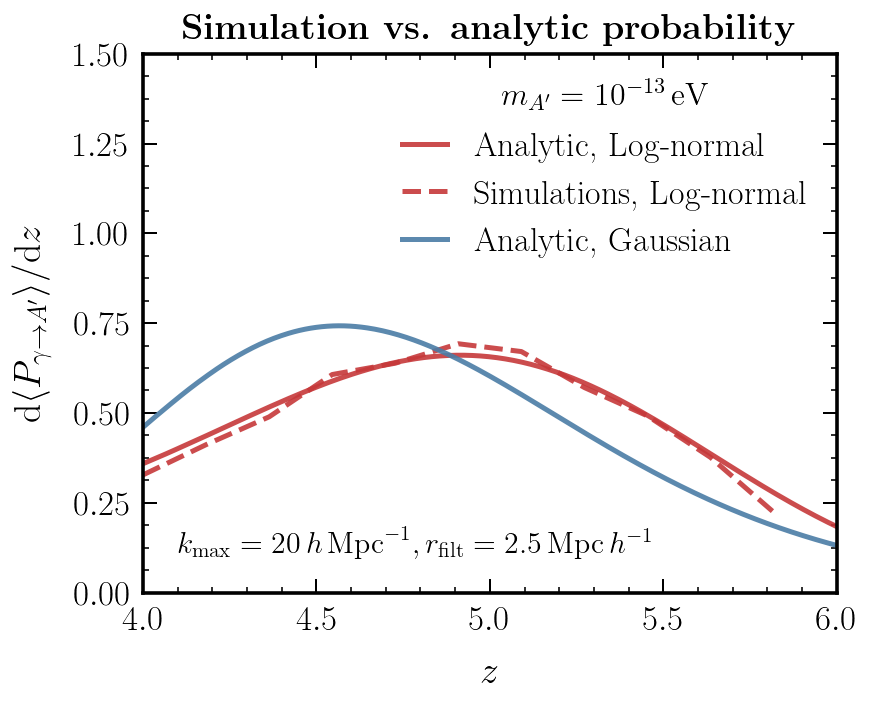

In [150]:
norm = (bin_centers[1] - bin_centers[0]) * np.sum(np.mean(y, axis=0))

plt.plot(z_ary, dP_dz_ary  / np.trapz(dP_dz_ary[(z_ary > z_range[0]) * (z_ary < z_range[1])], z_ary[(z_ary > z_range[0]) * (z_ary < z_range[1])]), label="Analytic, Log-normal", color=cols_default[0])

# plt.plot(bin_centers, np.percentile(y, [16], axis=0)[0] / norm, label="Simulations, Lognormal")
plt.plot(bin_centers, np.mean(y, axis=0) / norm, label="Simulations, Log-normal", color=cols_default[0], ls='--', )
# plt.plot(bin_centers, np.percentile(y, [84], axis=0)[0] / norm, label="Simulations, Lognormal")

plt.plot(z_ary, dP_dz_ary_gauss  / np.trapz(dP_dz_ary_gauss[(z_ary > z_range[0]) * (z_ary < z_range[1])], z_ary[(z_ary > z_range[0]) * (z_ary < z_range[1])]), label="Analytic, Gaussian", color=cols_default[1])

plt.xlim(z_range[0], z_range[1])
plt.ylim(0, 1.5)
plt.ylabel(r"$\mathrm{d}\langle P_{\gamma\to A'}\rangle/\mathrm{d}z$")
plt.xlabel("$z$")
plt.text(4.1, 0.1, "$k_\mathrm{max}=20\,h\,\mathrm{Mpc}^{-1}, r_\mathrm{filt}=2.5\,\mathrm{Mpc}\,h^{-1}$", fontsize=15)

# plt.text(r"$m_{A'} = 10^{-13}$\,eV")
plt.title(r"\bf{Simulation vs. analytic probability}")
leg = plt.legend(handlelength=1.3)
leg.set_title(title=r"$m_{A'} = 10^{-13}$\,eV", prop = {'size':16})

plt.tight_layout()
plt.savefig(plots_dir + "dPdz_LN_sims.pdf")

In [151]:
z_fid = 5
z_range = [4, 6]
k_max = 15
n_points = 100
seed = 42

GRFB = GaussianRandomFieldBoxes(z_fid=z_fid, z_range=z_range, k_max=k_max, n_points=n_points, r_filter=2, log_pk_interp=pspec, z_dep_P=1, run=False)
GRFB.get_box_properties()
GRFB.simulate_grf(seeds=np.arange(seed, seed + GRFB.n_boxes))

/Users/smsharma/anaconda3/lib/python3.7/site-packages/nbodykit/filters.py:31: RuntimeWarning: invalid value encountered in true_divide
  w = 3 * (numpy.sin(kr) / kr **3 - numpy.cos(kr) / kr ** 2)
/Users/smsharma/anaconda3/lib/python3.7/site-packages/nbodykit/filters.py:31: RuntimeWarning: divide by zero encountered in true_divide
  w = 3 * (numpy.sin(kr) / kr **3 - numpy.cos(kr) / kr ** 2)


In [152]:
sigmas = [np.sqrt(np.var(GRFB.fields[i_b])) for i_b in range(GRFB.n_boxes)]

../grf/simulations.py:254: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(np.nan_to_num(self.one_plus_delta_ary))


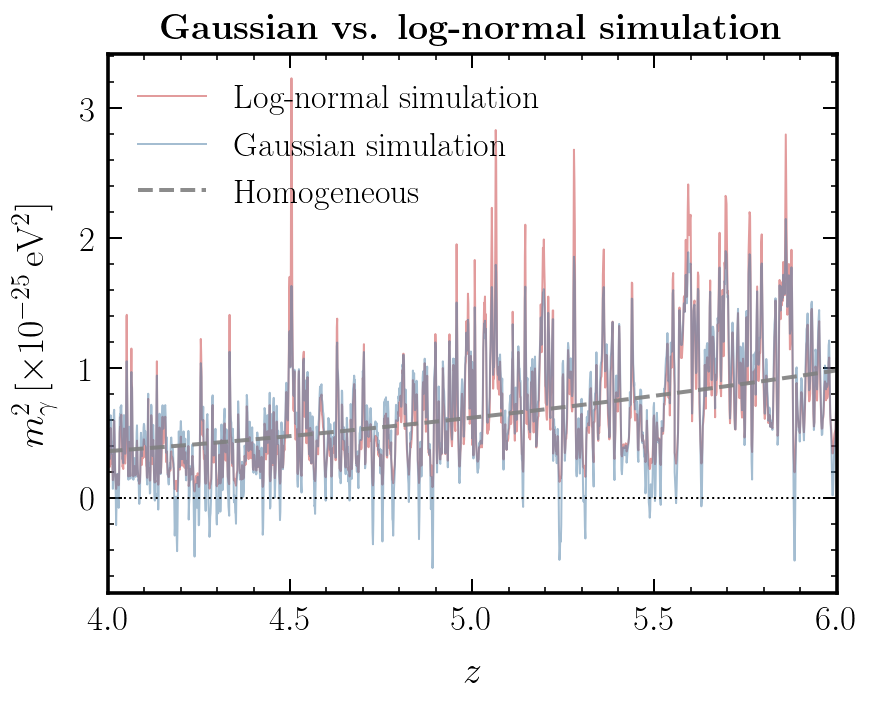

In [153]:
GRFB.calculate_transition_prob_custom([lognormal_transform(GRFB.fields[i_b][0, :, 0] - 1., sigmas[i_b]) for i_b in range(GRFB.n_boxes)])
plt.plot(GRFB.z_ary_new, np.array(GRFB.m_A_sq_perturb_ary) / (1e-25 * eV ** 2), lw=1., alpha=0.5, label="Log-normal simulation")
# x = np.array(GRFB.m_A_sq_perturb_ary)
# np.random.shuffle(x)
GRFB.calculate_transition_prob_custom([(GRFB.fields[i_b][0, :, 0]) for i_b in range(GRFB.n_boxes)])
plt.plot(GRFB.z_ary_new, np.array(GRFB.m_A_sq_perturb_ary) / (1e-25 * eV ** 2), lw=1., alpha=0.5, label="Gaussian simulation")
plt.plot(GRFB.z_ary_new, np.array(GRFB.m_A_sq_ary) / (1e-25 * eV ** 2), lw=2., ls='--', color='grey', label="Homogeneous")

# plt.plot(GRFB.z_ary_new, x / (1e-25 * eV ** 2), lw=0.1, label="Shuffle")


plt.axhline(0, lw=1, color='black', ls='dotted')

plt.xlim(z_range[0], z_range[1])
plt.xlabel(r"$z$")
plt.ylabel(r"$m_\gamma^2\,[\times 10^{-25}$\,eV$^2$]")

plt.title(r"\bf{Gaussian vs. log-normal simulation}")

plt.legend()

plt.tight_layout()
plt.savefig(plots_dir + "m_gamma_sq_LN_sims.pdf")

/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


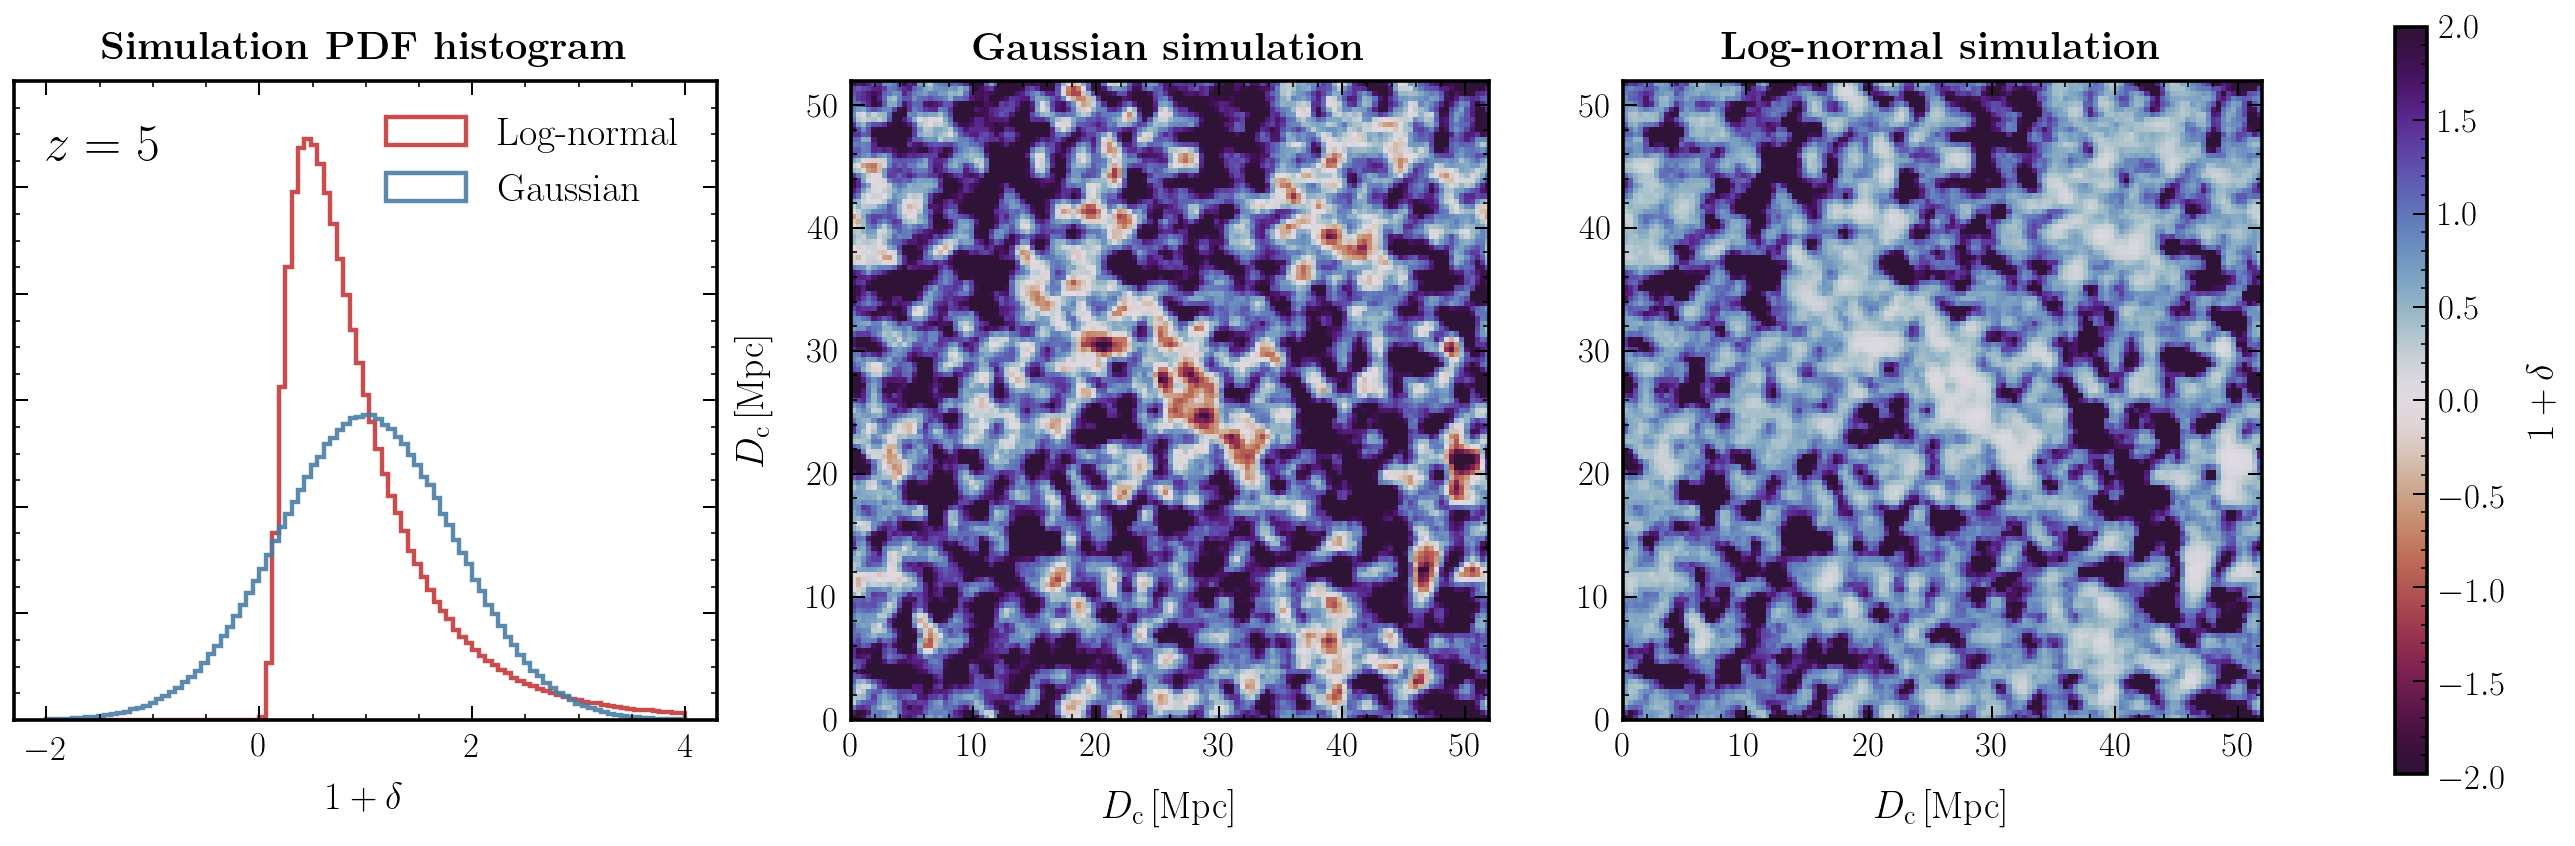

In [154]:
vmin = -2
vmax = 2
cmap = 'twilight_shifted_r'

# Make plot!
plt.rcParams['figure.constrained_layout.use'] = True
fig = plt.figure(figsize=(18, 6)) 

## Define gridspec
gs = gridspec.GridSpec(1, 4, width_ratios=[1.1, 1, 1, .05]) 

ax0 = plt.subplot(gs[0])
ax0.set_aspect(6 / 120000)
ax0.set_ylim(0, 120000)

bins = np.linspace(-2, 4, 100)
ax0.hist(lognormal_transform(GRFB.fields[0] - 1., sigmas[0]).flatten(), bins=bins, histtype='step', lw=2.2, label="Log-normal");
ax0.hist(GRFB.fields[0].flatten(), bins=bins, histtype='step', lw=2.2, label="Gaussian");
ax0.set_title(r"\bf{Simulation PDF histogram}", fontsize=20, y=1.01)
ax0.get_yaxis().set_ticklabels([])
ax0.legend(fontsize=20)
ax0.set_xlabel(r"$1 + \delta$")
ax0.text(-2, 105000, r"$z=5$", fontsize=26)


ax1 = plt.subplot(gs[1])

cd = GRFB.d_comoving_bins[1] - GRFB.d_comoving_bins[0] 

ax1.imshow(GRFB.fields[0][0],
          vmin=vmin, vmax=vmax,
          cmap=cmap,
          extent=[0, cd, 0, cd],

)

ax1.set_xlabel("$D_{\mathrm c}$\,[Mpc]", labelpad=15)
ax1.set_ylabel("$D_{\mathrm c}$\,[Mpc]", labelpad=15)
ax1.set_title(r"\bf{Gaussian simulation}", fontsize=20, y=1.01)

ax2 = plt.subplot(gs[2])

ax2.set_xlabel("$D_{\mathrm c}$\,[Mpc]", labelpad=15)
ax2.set_title(r"\bf{Log-normal simulation}", fontsize=20, y=1.01)

im = ax2.imshow(lognormal_transform(GRFB.fields[0][0, :, :] - 1., sigmas[0]),
          cmap=cmap,
          vmin=vmin, vmax=vmax,
          extent=[0, cd, 0, cd])

ax3 = plt.subplot(gs[3])

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes()
cbar = plt.colorbar(im, cax=ax3, shrink=1e-3)
cbar.set_label(r"$1 + \delta$")

plt.tight_layout()
plt.savefig(plots_dir + "hist_LN_sims.pdf")